In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "Courier New"
import seaborn as sns
import copy

from maze_class import *
from initial_monte_carlo import *

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
MAX_EP = 3000
STEP_COST = -0.1
MAX_EP_LEN = 30

maze_coords = {
    "[0, 0]": 0, "[0, 1]": 1, "[0, 2]": 2, "[0, 3]": 3,
    "[1, 0]": 4, "[1, 1]": 5, "[1, 2]": 6, "[1, 3]": 7,
    "[2, 0]": 8, "[2, 1]": 9, "[2, 2]": 10, "[2, 3]": 11,
    "[3, 0]": 12, "[3, 1]": 13, "[3, 2]": 14, "[3, 3]": 15
}

reversed_maze = {
    "0": [0, 0], "1": [0, 1], "2": [0, 2], "3": [0, 3],
    "4": [1, 0], "5": [1, 1], "6": [1, 2], "7": [1, 3],
    "8": [2, 0], "9": [2, 1], "10": [2, 2], "11": [2, 3],
    "12": [3, 0], "13": [3, 1], "14": [3, 2], "15": [3, 3],
}

env = Maze(maze_coords,reversed_maze, step_cost=STEP_COST, max_ep_length=MAX_EP_LEN)

In [3]:
# factor 1
policy_eval1 = mc_evaluation_policy(env, discount_factor=1)

# factor 0.99
policy_eval2 = mc_evaluation_policy(env, discount_factor=0.9)

In [4]:
def plot_state_value_grid(state_value_grid):
    """
    """
    plt.figure(figsize=(10,5))
    p=sns.heatmap(state_value_grid, cmap='coolwarm', annot=True, fmt=".1f",annot_kws={'size':16},square=True)
    p.set_ylim(len(state_value_grid)+0.01, -0.01)

#### Factor 1

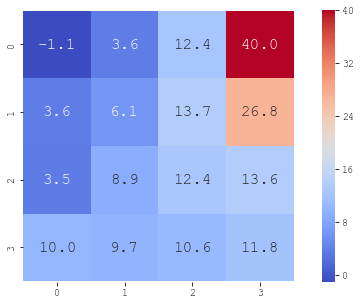

In [5]:
plot_state_value_grid(policy_eval1.reshape((4,4)))


#### Factor 0.9

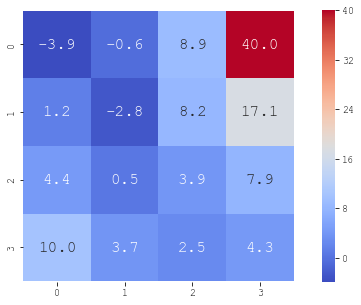

In [6]:
plot_state_value_grid(policy_eval2.reshape((4,4)))